In [1]:
import gym
from gym import spaces
from gym.utils import seeding
import itertools
import logging
import numpy as np
from collections import deque
import itertools

In [3]:
import keras
from keras.models import Sequential
from keras.layers import Dense,Dropout,Flatten
from keras.optimizers import Adam
from keras import layers

In [4]:
#Importing the Game Board
from Game_Board import*
max_tile=[]

In [5]:
#Converting observations in range (0,1) using log(n)/log(max) so that gradients don't vanish
def process_log(observation):
        observation = np.reshape(observation, (4, 4))
        observation_temp = np.where(observation <= 0, 1, observation) 
        processed_observation = np.log2(observation_temp)/np.log2(65536)
        return processed_observation.reshape(1,4,4)

In [6]:
def get_grids_next_step(grid):
        #Returns the next 4 states s' from the current state s
        
        grids_list = []
        
        for movement in range(4):
            grid_before = grid.copy()
            env1=Game2048Env()
            env1.set_board(grid_before)
            try:
                _= env1.move(movement) 
            except:
                pass
            grid_after =env1.get_board()
            env1.get_board()
            grids_list.append(grid_after)
            
        return grids_list

In [7]:
class DQN:
    def __init__(self,env):
        #Defining the hyperparameters for the model
        self.env=env.get_board()
        #The replay memory will be stored in a Deque
        self.memory=deque(maxlen=2000)
        self.gamma=0.90
        self.epsilon=1.0
        self.epsilon_min=0.01
        self.epsilon_decay=0.995
        self.learning_rate=0.005
        self.tau=0.125
        #We use 2 models to prevent Bootstrapping
        self.model=self.create_model()
        self.target_model=self.create_model()
        
        
    def create_model(self):
        model=Sequential()
        state_shape=4
                
        model.add(Flatten(input_shape=(4,4)))
        model.add(Dense(units=1024,activation="relu"))
        model.add(Dense(units=512,activation="relu"))
        model.add(Dense(units=256,activation="relu"))
        model.add(Dense(units=4))
        model.compile(loss="mean_squared_error",optimizer=Adam(lr=self.learning_rate))
        print(model.summary())
        return model
                  
    def act(self,state):
        #Epsilon value decays as model gains experience
        self.epsilon*=self.epsilon_decay
        self.epsilon=max(self.epsilon_min,self.epsilon)
        if np.random.random()<self.epsilon:
                  return np.random.randint(0,4)
        else:
            #Getting the 4 future states
            allstates=get_grids_next_step(state)
            
            res=[]
            for i in range(len(allstates)):
                if (allstates[i]==state).all():
                    res.append(0)
                else:
                    processed_state=process_log(allstates[i])
                    #max from the 4 future Q_Values is appended in res
                    res.append(np.max(self.model.predict(processed_state)))
            
            a=self.model.predict(process_log(state))
            #Final Q_Values are the sum of Q_Values of current state andfuture states
            final=np.add(a,res)
            
            return np.argmax(final)
    
    def remember(self, state, action, reward, new_state, done):
        #Replay Memory stores tuple(S, A, R, S')
        self.memory.append([state, action, reward, new_state, done])

    def replay(self):
        batch_size=32
        if len(self.memory)<batch_size:
            return
        samples=random.sample(self.memory,batch_size)
        for sample in samples:
            
            state,action,reward,new_state,done=sample
            
            target=self.target_model.predict(process_log(state))
            
            
            if done:
                target[0][action]=reward
            else:
                #Bellman Equation for update
                Q_future=max(self.target_model.predict(process_log(new_state))[0])
                
                #The move which was selected, its Q_Value gets updated
                target[0][action]=reward+Q_future*self.gamma
            self.model.fit((process_log(state)),target,epochs=1,verbose=0)
                  
                  
    def target_train(self):
        weights=self.model.get_weights()
        target_weights=self.target_model.get_weights()
        for i in range(len(target_weights)):
            target_weights[i]=weights[i]*self.tau+target_weights[i]*(1-self.tau)
        self.target_model.set_weights(target_weights)
                  
                  
    def save_model(self,fn):
        self.model.save(fn)
                  
                  


In [9]:

def main():
    env=Game2048Env()
    gamma=0.9
    epsilon=0.95
    
    trials=1000
    trial_len=500
    dqn_agent=DQN(env=env)
    steps=[]
    
    
    
    for trial in range(trials):
        env.reset()
        cur_state=env.get_board()
        
        cur_state=cur_state.reshape(4,4)
        stepno=0
        
        for step in range(trial_len):
            stepno+=1
            
            action=dqn_agent.act(cur_state)
            
            _,reward,done,_=env.step(action)
            new_state=env.get_board()
            
            dqn_agent.remember(cur_state,action,reward,new_state,done)
            if step%10==0:
                dqn_agent.replay()
                dqn_agent.target_train()
            
            cur_agent=new_state
            
            if done:
                
                break
        
        if stepno<500:
            
            if env.highest()==2048:
                print("Completed in --",trial)
                print(env.get_board())
                max_tile.append(env.highest())

                dqn_agent.save_model("success.model")

            
            else:
                print(f"Trial number {trial} Failed to complete in 500 steps")
                print(env.get_board())
                max_tile.append(env.highest())
                if env.highest()>=512:
                    dqn_agent.save_model("trial num-{}.model".format(trial))
                    
        else:
            print(f"Failed to complete in 500 steps")
            print(env.get_board())
            max_tile.append(env.highest())

            
if __name__ == "__main__":
    main()  

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 16)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 1024)              17408     
_________________________________________________________________
dense_10 (Dense)             (None, 512)               524800    
_________________________________________________________________
dense_11 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_12 (Dense)             (None, 4)                 1028      
Total params: 674,564
Trainable params: 674,564
Non-trainable params: 0
_________________________________________________________________
None
Model: "sequential_4"
_________________________________________________________________
Layer (type)         

Trial number 51 Failed to complete in 500 steps
[[  8   2   4   2]
 [ 32  16   8   4]
 [ 64  32  16   8]
 [128   2   8   2]]
Trial number 52 Failed to complete in 500 steps
[[ 16   8   4   2]
 [ 32  16   8   4]
 [128  32  16   8]
 [256   8  32  16]]
Trial number 53 Failed to complete in 500 steps
[[  8   2   4   2]
 [ 16   8   2   4]
 [ 32  16   8  16]
 [128   2  32   2]]
Trial number 54 Failed to complete in 500 steps
[[ 32  16   4   2]
 [ 64  32   8   4]
 [  4  64  32   8]
 [128   2  64  16]]
Trial number 55 Failed to complete in 500 steps
[[ 16   8   4   2]
 [ 64  32   8   4]
 [128  64  32  16]
 [256 128   4   2]]
Trial number 56 Failed to complete in 500 steps
[[  4   2   8   2]
 [ 16   4   2   4]
 [ 32  16   4   8]
 [128  32  16   4]]
Trial number 57 Failed to complete in 500 steps
[[ 32   8   4   2]
 [ 64  32   8   4]
 [256  64  16   8]
 [ 32   2  32  16]]
Trial number 58 Failed to complete in 500 steps
[[16  8  4  2]
 [32 16  8  4]
 [64 32 16  8]
 [ 2  4 64  2]]
Trial number 59 

Trial number 118 Failed to complete in 500 steps
[[  2   8   4   2]
 [  4  64   8   4]
 [128  32  16   8]
 [  2 256   8  16]]
Trial number 119 Failed to complete in 500 steps
[[ 16   8   4   2]
 [  2  32   8   4]
 [ 32  64  16   8]
 [  4 128   8   2]]
Trial number 120 Failed to complete in 500 steps
[[ 16   8   4   2]
 [ 64  32   8   4]
 [  4  64  32   8]
 [  2 256  64   2]]
Trial number 121 Failed to complete in 500 steps
[[ 8  4  2  4]
 [32  8  4  2]
 [64 32 16  4]
 [ 8  4 32  2]]
Trial number 122 Failed to complete in 500 steps
[[ 16   4   2   4]
 [ 32   8   4   2]
 [ 64  16   8   4]
 [256 128  16   2]]
Trial number 123 Failed to complete in 500 steps
[[ 16   8   4   2]
 [ 64  16   8   4]
 [128  64  32   8]
 [256 128   4   2]]
Trial number 124 Failed to complete in 500 steps
[[ 16   8   4   2]
 [ 32  16   8   4]
 [128  64   2   8]
 [ 16   8   4   2]]
Trial number 125 Failed to complete in 500 steps
[[ 4  2 16  4]
 [32 16  4  2]
 [ 2 32  8  4]
 [32  8  4  2]]
Trial number 126 Failed 

Trial number 185 Failed to complete in 500 steps
[[ 16   8   4   2]
 [ 32  16   8   4]
 [128  32  16   8]
 [256   2  32   2]]
Trial number 186 Failed to complete in 500 steps
[[16  8  4  2]
 [ 4 16  2  4]
 [ 8  2 16  8]
 [64 16 32  4]]
Trial number 187 Failed to complete in 500 steps
[[ 16   8   2   4]
 [ 32  16   8   2]
 [128  32   4   8]
 [  4  64  16   2]]
Trial number 188 Failed to complete in 500 steps
[[ 16   8   4   2]
 [ 64  16   8   4]
 [512  64  16   8]
 [ 16   2   4   2]]
Trial number 189 Failed to complete in 500 steps
[[ 16   8   4   2]
 [ 32   2  16   4]
 [256  16  64   2]
 [  2  64  32   4]]
Trial number 190 Failed to complete in 500 steps
[[ 16   8   4   2]
 [ 32  16   8   4]
 [ 64  32  16   8]
 [256  16  32  16]]
Trial number 191 Failed to complete in 500 steps
[[16  2  4  2]
 [32  8  2  4]
 [64 32  8 16]
 [ 2 64 32  4]]
Trial number 192 Failed to complete in 500 steps
[[ 16   8   2   4]
 [  2  64   4   2]
 [ 64   2   8   4]
 [256  64  16   2]]
Trial number 193 Failed 

Trial number 253 Failed to complete in 500 steps
[[  2  16   2   4]
 [ 64  32  16   2]
 [  2  64  32   8]
 [128  32   4   2]]
Trial number 254 Failed to complete in 500 steps
[[16  8  4  2]
 [ 2 16  8  4]
 [64  8  4  8]
 [ 4 32 16  2]]
Trial number 255 Failed to complete in 500 steps
[[ 8  4  2  4]
 [32 16  4  2]
 [ 4  2  8 16]
 [64 32  4  2]]
Trial number 256 Failed to complete in 500 steps
[[  8   4   2   4]
 [ 64  16   8   2]
 [128  32  16   8]
 [  8   2  32   2]]
Trial number 257 Failed to complete in 500 steps
[[ 16   2   8   4]
 [128  32  16   2]
 [  2  64  32   8]
 [256 128  16   2]]
Trial number 258 Failed to complete in 500 steps
[[ 16   8   4   2]
 [ 64  32   8   4]
 [128  64  16   8]
 [ 32   8   2   4]]
Trial number 259 Failed to complete in 500 steps
[[ 16   8   2   4]
 [ 64  16   4   2]
 [  2  32  16   4]
 [256   8  32  16]]
Trial number 260 Failed to complete in 500 steps
[[16  8  4  2]
 [32 16  8 16]
 [64 32  4  2]
 [ 4 64 32  4]]
Trial number 261 Failed to complete in 5

Trial number 320 Failed to complete in 500 steps
[[  2   8   4   2]
 [ 32  16   8   4]
 [ 64  32  16   8]
 [128   2   8   2]]
Trial number 321 Failed to complete in 500 steps
[[ 2  8  4  2]
 [32 16  8  4]
 [ 2 32 64 16]
 [32  8  4  2]]
Trial number 322 Failed to complete in 500 steps
[[  8   4   2   4]
 [ 16   8   4   8]
 [ 64  32  16   4]
 [128   4  32   2]]
Trial number 323 Failed to complete in 500 steps
[[  8   2   4   2]
 [ 32  16   8   4]
 [ 64  32  16   8]
 [256  64   4   2]]
Trial number 324 Failed to complete in 500 steps
[[ 16   4   8   2]
 [ 64  16  32   8]
 [128   4   8  16]
 [  2  64   4   2]]
Trial number 325 Failed to complete in 500 steps
[[  2   8   4   2]
 [ 64  16   8   4]
 [128  64  16   8]
 [ 64  16   4   2]]
Trial number 326 Failed to complete in 500 steps
[[  8   4   2   4]
 [  4  16   4   2]
 [ 64  32   8   4]
 [128   4   2   8]]
Trial number 327 Failed to complete in 500 steps
[[ 32  16   4   2]
 [  2  32  16   4]
 [256   8  32   8]
 [  2 128   8   4]]
Trial nu

Trial number 388 Failed to complete in 500 steps
[[  8   2   4   2]
 [ 32   8   2   4]
 [  2  16   8   2]
 [ 32 128  32  16]]
Trial number 389 Failed to complete in 500 steps
[[  2   8   4   2]
 [  4  64   8   4]
 [ 16 128  64  16]
 [256   8   2  32]]
Trial number 390 Failed to complete in 500 steps
[[  2  16   2   4]
 [ 64   8   4   2]
 [128  32   8   4]
 [  2 128  16   8]]
Trial number 391 Failed to complete in 500 steps
[[  8   2   4   2]
 [ 16   4   8   4]
 [128  64  16   2]
 [  2 128  64   8]]
Trial number 392 Failed to complete in 500 steps
[[  8   2   8   4]
 [ 64  32   4   2]
 [  2  64  16   4]
 [256 128  32   8]]
Trial number 393 Failed to complete in 500 steps
[[ 16   8   4   2]
 [ 32   2   8   4]
 [128   4  16   8]
 [  2 128  64   2]]
Trial number 394 Failed to complete in 500 steps
[[  2   8   4   2]
 [ 16  64   8   4]
 [128  32  16   8]
 [256 128   4   2]]
Trial number 395 Failed to complete in 500 steps
[[ 16   4   2   4]
 [ 32   2   4   8]
 [  2  32   8   2]
 [128   4  1

Trial number 456 Failed to complete in 500 steps
[[  2  32   2   4]
 [  4  16   8   2]
 [  8   2  16   4]
 [128  16   2  16]]
Trial number 457 Failed to complete in 500 steps
[[ 4  8  4  2]
 [ 2 16  8  4]
 [ 4 32 16  2]
 [ 8 64 32 16]]
Trial number 458 Failed to complete in 500 steps
[[  4   8   4   2]
 [ 32  16   8   4]
 [  4  32  16   8]
 [256   4  32  16]]
Trial number 459 Failed to complete in 500 steps
[[  4   8   2   8]
 [ 32  16   4   2]
 [  4   2  16   8]
 [ 32 128   2  16]]
Trial number 460 Failed to complete in 500 steps
[[ 16   2   8   4]
 [ 32   8   4   2]
 [256  64  16   4]
 [  2 128  64  32]]
Trial number 461 Failed to complete in 500 steps
[[ 2  8  2  4]
 [16  2  4  2]
 [ 2 32  8  4]
 [64 16  4  2]]
Trial number 462 Failed to complete in 500 steps
[[  4   8   4   2]
 [  2  16   8   4]
 [  4 128   2   8]
 [  8 256  32  16]]
Trial number 463 Failed to complete in 500 steps
[[ 16   8   4   2]
 [  4  32  16   4]
 [  2  64  32  16]
 [ 64 256 128  32]]
Trial number 464 Failed 

Trial number 523 Failed to complete in 500 steps
[[  2  16   2   4]
 [ 32   2   8   2]
 [128  32  16   4]
 [  2  64   8   2]]
Trial number 524 Failed to complete in 500 steps
[[ 16   8   4   2]
 [  2  16   8   4]
 [128  64   4   8]
 [  8 128  64   4]]
Trial number 525 Failed to complete in 500 steps
[[ 16   4   2   4]
 [ 32  16   4   2]
 [ 64  32   8   4]
 [256  64  32   8]]
Trial number 526 Failed to complete in 500 steps
[[ 8  2  4  2]
 [16  8 16  4]
 [64  2 32  8]
 [ 4 64  4 16]]
Trial number 527 Failed to complete in 500 steps
[[  4   2   8   4]
 [ 32  16   2   8]
 [128  32  16   2]
 [  4  64  32   8]]
Trial number 528 Failed to complete in 500 steps
[[ 8  4  2  4]
 [32 16  4  2]
 [ 4 64  2  8]
 [32  4  8  4]]
Trial number 529 Failed to complete in 500 steps
[[16  8  2  4]
 [32 16  4  2]
 [64 32  8  4]
 [ 4  2 16  2]]
Trial number 530 Failed to complete in 500 steps
[[ 16   8   4   2]
 [ 32  16   8   4]
 [  4  64  32  16]
 [128  16   4   2]]
Trial number 531 Failed to complete in 5

Trial number 591 Failed to complete in 500 steps
[[ 4 16  8  4]
 [ 8 64 16  2]
 [ 2 32  8  4]
 [ 8 64  2 16]]
Trial number 592 Failed to complete in 500 steps
[[32  2  4  2]
 [ 4 16  8  4]
 [32  2 16  8]
 [64 32  2 16]]
Trial number 593 Failed to complete in 500 steps
[[ 2 16  4  2]
 [ 4 32  8  4]
 [ 8 64 16  2]
 [64 16 64 16]]
Trial number 594 Failed to complete in 500 steps
[[ 2  4  8  2]
 [32 16  2  4]
 [ 8  2  8  2]
 [32  4 32 16]]
Trial number 595 Failed to complete in 500 steps
[[32  2  4  2]
 [ 4 32  8  4]
 [ 8  4 16  8]
 [32  8  2 16]]
Trial number 596 Failed to complete in 500 steps
[[  2  16   4   2]
 [  4   8  32   4]
 [ 64  32  16   8]
 [128  64  32  16]]
Trial number 597 Failed to complete in 500 steps
[[  2   8   4   2]
 [ 16  32   8   4]
 [ 32   4  32   8]
 [128   8   2  16]]
Trial number 598 Failed to complete in 500 steps
[[  2   4  64   8]
 [256  16   4   2]
 [  4   2  16   8]
 [ 64   8   2  32]]
Trial number 599 Failed to complete in 500 steps
[[ 2  8  4  2]
 [16 32 

Trial number 660 Failed to complete in 500 steps
[[32  8  4  2]
 [ 4 16  8  4]
 [64 32 16  2]
 [ 2 64 32 16]]
Trial number 661 Failed to complete in 500 steps
[[  2  16   8   4]
 [ 16  32  16   2]
 [ 64   4  32   4]
 [256  32   2  16]]
Trial number 662 Failed to complete in 500 steps
[[  4   8   4   2]
 [ 64  32   2   4]
 [  2  64   8  16]
 [  4 256  64   4]]
Trial number 663 Failed to complete in 500 steps
[[ 16   8   4   2]
 [ 64  16   8   4]
 [128  64  16   2]
 [ 16   4  32  16]]
Trial number 664 Failed to complete in 500 steps
[[ 8  2  4  2]
 [64 32  2  4]
 [ 2 64  4  2]
 [32  2 32  8]]
Trial number 665 Failed to complete in 500 steps
[[ 32   8   4   2]
 [  2  64   8   4]
 [128  32  16   8]
 [512 128  32   2]]
Trial number 666 Failed to complete in 500 steps
[[ 4 32  4  2]
 [64  4  2  4]
 [ 2 32 16  2]
 [ 4 64 32  4]]
Trial number 667 Failed to complete in 500 steps
[[  2   8   4   2]
 [  4  16   8   4]
 [  8 128  16   8]
 [ 64  16   2  16]]
Trial number 668 Failed to complete in 5

Trial number 727 Failed to complete in 500 steps
[[16  8  4  2]
 [32 16  8  4]
 [64 32 16  8]
 [ 4 64  2 32]]
Trial number 728 Failed to complete in 500 steps
[[  2   8   4   2]
 [ 64   2   8   4]
 [128  32  16   8]
 [  2  64  32   2]]
Trial number 729 Failed to complete in 500 steps
[[ 16   8   2   4]
 [ 64  32   8  16]
 [  4  64   2   4]
 [256 128  32   2]]
Trial number 730 Failed to complete in 500 steps
[[ 16   2   8   4]
 [ 32  16   4   2]
 [  2  32  16   4]
 [128  64  32   2]]
Trial number 731 Failed to complete in 500 steps
[[ 4 16  4  2]
 [64 32  8  4]
 [ 4 64 16  8]
 [64  2 32  2]]
Trial number 732 Failed to complete in 500 steps
[[ 16   2   8   4]
 [ 32   8   4   2]
 [  4  32   8   4]
 [128   4  32   8]]
Trial number 733 Failed to complete in 500 steps
[[ 16   8   4   2]
 [ 32  16   8   4]
 [ 64  32  16   8]
 [256   8  32  16]]
Trial number 734 Failed to complete in 500 steps
[[  8   4   2   4]
 [ 16   8   4   8]
 [  2  16  64  16]
 [256   8   2   4]]
Trial number 735 Failed 

Trial number 794 Failed to complete in 500 steps
[[ 8  4  2  4]
 [16  8  4  2]
 [32 16  8 16]
 [ 8 32  4  2]]
Trial number 795 Failed to complete in 500 steps
[[ 16   2   4   2]
 [ 32  16   8   4]
 [ 16   2  16   8]
 [128  64   4  16]]
Trial number 796 Failed to complete in 500 steps
[[ 16   8   4   2]
 [ 32  16   8   4]
 [128  64  16   8]
 [  4 128   4   2]]
Trial number 797 Failed to complete in 500 steps
[[  8   4   2   4]
 [ 64  32  16   2]
 [128  64  32   8]
 [  8 128   4  16]]
Trial number 798 Failed to complete in 500 steps
[[ 16   8   4   2]
 [  2  32   8   4]
 [128   2  32  16]
 [ 64  16   4   2]]
Trial number 799 Failed to complete in 500 steps
[[ 8  2  8  2]
 [32  8 32  4]
 [64 32 16  8]
 [32  8  2 16]]
Failed to complete in 500 steps
[[ 32   4   2   4]
 [128   8   8   2]
 [256  64  16   8]
 [512 128   2  16]]
Trial number 801 Failed to complete in 500 steps
[[ 16   2   8   2]
 [  2  16  64   8]
 [  4  64   2  16]
 [256   2  64   2]]
Trial number 802 Failed to complete in 50

Trial number 861 Failed to complete in 500 steps
[[ 16   8   4   2]
 [ 64  32  16   4]
 [128  64  32  16]
 [  2 128  64   4]]
Trial number 862 Failed to complete in 500 steps
[[ 2  8  4  2]
 [32 16  8  4]
 [ 4 64 32  8]
 [64 32  4  2]]
Trial number 863 Failed to complete in 500 steps
[[ 32   8   2   4]
 [128  16   8   2]
 [ 64  32  16   4]
 [256   2  64   2]]
Trial number 864 Failed to complete in 500 steps
[[ 16   8   4   2]
 [ 32  16   8   4]
 [128  64  16   8]
 [ 64   8   2  16]]
Trial number 865 Failed to complete in 500 steps
[[ 32   8   4   2]
 [ 64  32   8   4]
 [128  64  16   2]
 [ 64  16   8   4]]
Trial number 866 Failed to complete in 500 steps
[[ 16   8   4   2]
 [  2  32  16   4]
 [  4   2  32   8]
 [128  64   2  16]]
Trial number 867 Failed to complete in 500 steps
[[ 16   8   2   4]
 [ 32   2   8   2]
 [ 64  32   4   8]
 [128  64  16   2]]
Trial number 868 Failed to complete in 500 steps
[[32  8  4  2]
 [64 16  2  4]
 [ 2 32 16  2]
 [ 4 64 32  8]]
Trial number 869 Failed 

Trial number 928 Failed to complete in 500 steps
[[ 16   8   4   2]
 [ 64  16   8   4]
 [128  64  16   8]
 [ 16   8  64   4]]
Trial number 929 Failed to complete in 500 steps
[[  2   8   2   4]
 [  8  32   4   2]
 [ 64   2  16   8]
 [256  16  32   2]]
Trial number 930 Failed to complete in 500 steps
[[ 16   2   4   2]
 [ 64  32  16   4]
 [128  64  32   2]
 [  4   2  64   4]]
Trial number 931 Failed to complete in 500 steps
[[ 16   2   8   2]
 [128  32  64   4]
 [  2 128   8  16]
 [256  16   4   2]]
Trial number 932 Failed to complete in 500 steps
[[  8   4   2   4]
 [ 64  16   4   2]
 [256   2  16   4]
 [ 16  64  32   2]]
Trial number 933 Failed to complete in 500 steps
[[ 16   8   2   4]
 [  4   2   8   2]
 [  8   4  32   8]
 [  2 128   2   4]]
Trial number 934 Failed to complete in 500 steps
[[  2   8   4   2]
 [  4  32  16   4]
 [ 32 128  64  16]
 [256  16   4   2]]
Trial number 935 Failed to complete in 500 steps
[[ 8  4  2  4]
 [32  8  4  2]
 [64 16  8  4]
 [ 4 64 16  8]]
Trial nu

Trial number 996 Failed to complete in 500 steps
[[ 32  16   4   2]
 [ 64  32   8   4]
 [128  64  32   8]
 [256   8   4  16]]
Trial number 997 Failed to complete in 500 steps
[[  4   2   4   2]
 [  8  16   2   4]
 [ 16  32   4  16]
 [256   2  32   2]]
Trial number 998 Failed to complete in 500 steps
[[ 32   2   8   4]
 [  4  32  16   2]
 [ 64  16   8   4]
 [128  64  16   2]]
Trial number 999 Failed to complete in 500 steps
[[ 32   8   4   2]
 [ 64  16   8   4]
 [  4  32  16   8]
 [ 16 128  32  16]]


In [27]:
trialnum=np.arange(1002)

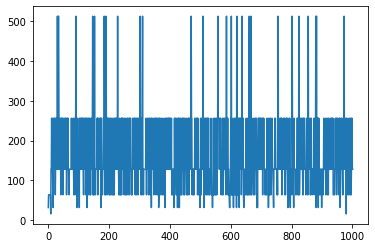

In [33]:
import matplotlib.pyplot as plt

plt.plot(trialnum,max_tile)
